## Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.5 MB/s eta 0:00:00
--- 1. Data Loading and Feature Engineering ---


[I 2025-05-22 17:28:09,813] A new study created in memory with name: no-name-1218d130-885f-4b74-8106-b35780c3689a



--- 2. Converting categorical data to numeric ---

--- 6. Hyperparameter Tuning with Optuna ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-22 17:28:34,245] Trial 0 finished with value: 0.7219744312445991 and parameters: {'n_estimators': 949, 'learning_rate': 0.054334111392104215, 'max_depth': 8, 'subsample': 0.8601998831179625, 'colsample_bytree': 0.6421058481165637, 'gamma': 0.4323101341309018, 'reg_alpha': 0.09648682488137139, 'reg_lambda': 0.060699524993381826, 'scale_pos_weight': 0.8768989978337998}. Best is trial 0 with value: 0.7219744312445991.
[I 2025-05-22 17:28:53,482] Trial 1 finished with value: 0.7243651570556784 and parameters: {'n_estimators': 605, 'learning_rate': 0.03641904519430264, 'max_depth': 7, 'subsample': 0.7115069654724883, 'colsample_bytree': 0.7135939310446058, 'gamma': 0.00722117977045772, 'reg_alpha': 0.435720019828369, 'reg_lambda': 0.16865374844163944, 'scale_pos_weight': 0.9512144944119202}. Best is trial 1 with value: 0.7243651570556784.
[I 2025-05-22 17:29:14,978] Trial 2 finished with value: 0.7197585645384307 and parameters: {'n_estimators': 556, 'learning_rate': 0.0815193419

<Figure size 1200x800 with 0 Axes>

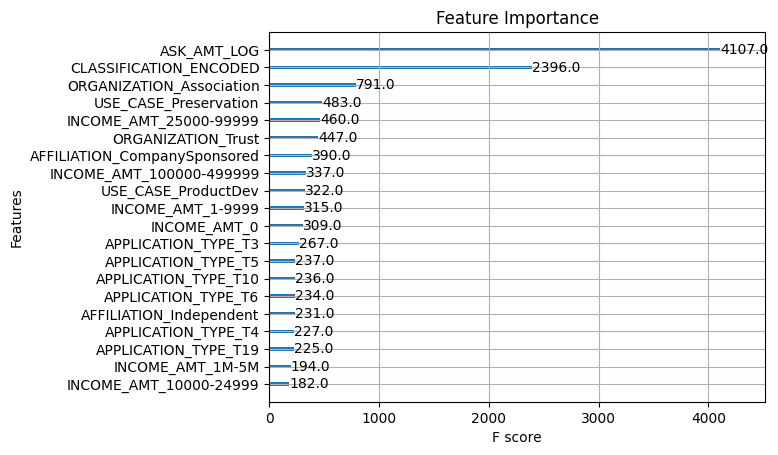

In [4]:
# --- Install all required packages ---
!pip install --quiet optuna category_encoders imblearn xgboost matplotlib pandas scikit-learn numpy

# --- Import dependencies ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import optuna
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# --- 1. Enhanced Data Loading and Feature Engineering ---
print("--- 1. Data Loading and Feature Engineering ---")

# Load data
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Feature: Log-transform ASK_AMT
application_df['ASK_AMT_LOG'] = np.log(application_df['ASK_AMT'] + 1)

# Feature: Target encoding for CLASSIFICATION (regularized by cross-validation later)
encoder = TargetEncoder(cols=['CLASSIFICATION'])
application_df['CLASSIFICATION_ENCODED'] = encoder.fit_transform(
    application_df['CLASSIFICATION'], application_df['IS_SUCCESSFUL']
)

# Drop non-beneficial columns (keeping CLASSIFICATION_ENCODED)
application_df = application_df.drop(columns=['EIN', 'NAME', 'ASK_AMT', 'CLASSIFICATION'])

# Group rare APPLICATION_TYPE values
app_counts = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(app_counts[app_counts < 500].index)
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app, "Other")

# --- 2. Convert categorical data to numeric ---
print("\n--- 2. Converting categorical data to numeric ---")
application_df = pd.get_dummies(application_df, columns=[
    'APPLICATION_TYPE', 'AFFILIATION', 'USE_CASE', 'ORGANIZATION',
    'INCOME_AMT', 'SPECIAL_CONSIDERATIONS'
], dtype=int)

# --- 3. Define Features (X) and Target (y) ---
X = application_df.drop(columns=['IS_SUCCESSFUL'])
y = application_df['IS_SUCCESSFUL']

# --- 4. Scale Numerical Features ---
numerical_cols = ['STATUS', 'ASK_AMT_LOG', 'CLASSIFICATION_ENCODED']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# --- 5. Cross-Validation Setup ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 6. Hyperparameter Tuning with Optuna ---
print("\n--- 6. Hyperparameter Tuning with Optuna ---")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2),
        'random_state': 42,
        'tree_method': 'hist',
        'eval_metric': 'logloss'
    }

    # Use SMOTE only on training folds
    model = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', xgb.XGBClassifier(**params))
    ])

    score = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Best trial: {study.best_trial.value:.4f}")
print("Best params:")
print(study.best_params)

# --- 7. Train Final Model with Best Params ---
print("\n--- 7. Training Final Model ---")

best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'tree_method': 'hist',
    'eval_metric': 'logloss'
})

# Get out-of-fold predictions for threshold optimization
oof_predictions = np.zeros(len(X))
oof_true = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train_res, y_train_res)

    oof_predictions[val_idx] = model.predict_proba(X_val)[:, 1]
    oof_true[val_idx] = y_val

# --- 8. Optimize Classification Threshold ---
print("\n--- 8. Threshold Optimization ---")

# Find optimal threshold using Youden's J statistic
fpr, tpr, thresholds = roc_curve(oof_true, oof_predictions)
youden_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[youden_idx]

# Alternative: Find threshold for max accuracy
accuracies = []
thresholds_range = np.linspace(0.01, 0.99, 100)
for t in thresholds_range:
    acc = accuracy_score(oof_true, (oof_predictions > t).astype(int))
    accuracies.append(acc)
best_threshold_acc = thresholds_range[np.argmax(accuracies)]

print(f"Best threshold (Youden): {best_threshold:.3f}")
print(f"Best threshold (Accuracy): {best_threshold_acc:.3f}")

# Use the threshold that gives higher accuracy
final_threshold = best_threshold_acc if accuracies[np.argmax(accuracies)] > accuracy_score(
    oof_true, (oof_predictions > best_threshold).astype(int)) else best_threshold

# --- 9. Train Final Model on Full Data ---
print("\n--- 9. Final Model Training ---")

# Apply SMOTE to full dataset (only for final training)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_res, y_res)

# --- 10. Evaluate Final Model ---
print("\n--- 10. Final Evaluation ---")

# Predict with optimized threshold
y_pred_proba = final_model.predict_proba(X)[:, 1]
y_pred = (y_pred_proba > final_threshold).astype(int)

final_accuracy = accuracy_score(y, y_pred)
final_roc_auc = roc_auc_score(y, y_pred_proba)

print(f"Final Accuracy (threshold={final_threshold:.3f}): {final_accuracy:.4f}")
print(f"Final ROC AUC: {final_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# --- 11. Feature Importance ---
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20)
plt.title("Feature Importance")
plt.show()
